Prérequis : installer via conda les packages seaborn et sklearn (scikit-learn)

In [ ]:
import pandas as pd
import seaborn as sns

- on charge les données : un jeu d'entrainement pour entrainer notre modele, et un jeu de test pour évaluer les performances

In [2]:
df = pd.read_csv("data/train.csv")

## Exploration des données 

Regardons le jeu de données

In [3]:
print(df.shape)

(891, 12)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

On a 3 colonnes avec des colonnes manquantes qu'il faudra traiter

In [6]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

- on observe des types de données très variés. Les modèles de machine learning attendent en entrées des colonnes de valeurs flottantes (ou assimilables : entieres, booleennes) : il
    faudra pre-processer ou supprimmer les autres colonnes.

<AxesSubplot:ylabel='Survived'>

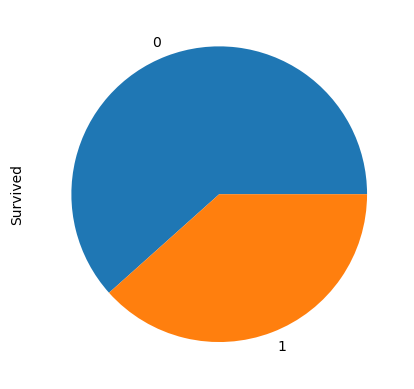

In [7]:
df["Survived"].value_counts().plot(kind="pie")

Un jeu de donnée relativement équilibré.
Pourquoi il faut regarder cela ? Parce que lorsque le jeu n'est pas équilibré :
- il y a un biais possible des modèles à l'entrainement 
- toutes les métriques d'évaluations ne seront pas pertinentes 

## Preprocessing

- on extrait notre label : la colonne que l'on veut prédire 

In [8]:
X, y = df.drop(columns="Survived"), df["Survived"]

On sépare en jeu d'entrainement et d'évaluation

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

- On peut supprimer des colonnes peu intéressantes

In [10]:
def drop_columns(df, columns_to_drop):
    for column in columns_to_drop:
        df.drop(columns=[column], axis=1, inplace=True)
    return df

In [11]:
columns_to_drop = ["Name", "Ticket", "Cabin"]
X_train = drop_columns(X_train, columns_to_drop)
X_test = drop_columns(X_test, columns_to_drop)

- On peut transformer en flottant des données sous formes de catégories.
- beaucoup de modeles apprennent mal sur des données sous formes de categories

In [12]:
def get_dummies_df(df, categorical_columns):
    for column in categorical_columns:
        if column in df.columns:
            _df = pd.get_dummies(df[column])
            df = pd.concat([df, _df], axis=1, sort=False)
            df.drop(columns=[column], inplace=True)
    return df

In [13]:
categorical_columns = ["Sex", "Embarked"]
X_train = get_dummies_df(X_train, categorical_columns)
X_test =  get_dummies_df(X_test, categorical_columns)

On peut remplacer les valeurs NAN pour les deux datasets, par exemple par la moyenne de la colonne.

In [14]:
def replace_nan(df, Nan_columns):
    for column in Nan_columns:
        if column in df.columns:
            df[Nan_columns] = df[Nan_columns].fillna(df[Nan_columns].mean())
    return df

In [15]:
Nan_columns = ["Age", "Fare"]
X_train = replace_nan(X_train, Nan_columns)
X_test = replace_nan(X_test, Nan_columns)

# Model

- choisissons un modele simple pour commencer : un arbre de decision

In [16]:
from sklearn.tree import DecisionTreeClassifier

- entrainons le sur notre jeu d'entrainement

In [17]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

### Testons le modèle entrainé

- Sur un exemple d'entrainement

In [31]:
example = X_train.iloc[0]
example

PassengerId    431.00
Pclass           1.00
Age             28.00
SibSp            0.00
Parch            0.00
Fare            26.55
female           0.00
male             1.00
C                0.00
Q                0.00
S                1.00
Name: 430, dtype: float64

- Quel était le label ? (la bonne réponse)

False : Le passager n'a pas survécu 

True : le passager a survécu

In [32]:
bool(y_train[X_train.index[0]])

True

- Vérifions maintenant la prédiction du modèle

In [34]:
bool(clf.predict([example]))

C:\Users\maxime.carrere\Miniconda3\envs\maths_ml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


False

Le modèle a-t-il donné la bonne réponse ?

### Vérifions maintenant sur un nouvel exemple, jamais utilisé lors de l'entrainement

In [35]:
example = X_test.iloc[0]
example

PassengerId    262.0000
Pclass           3.0000
Age              3.0000
SibSp            4.0000
Parch            2.0000
Fare            31.3875
female           0.0000
male             1.0000
C                0.0000
Q                0.0000
S                1.0000
Name: 261, dtype: float64

In [36]:
print("Label associé : ",bool(y_train[X_train.index[0]]))

Label associé :  True


In [38]:
bool(clf.predict([example]))

C:\Users\maxime.carrere\Miniconda3\envs\maths_ml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


True

Notre modèle a bien généralisé, et est capable de donner la bonne réponse sur un nouvel exemple

- Un seul exemple ce n'est pas représentatif. Il nous faut maintenant évaluer les performances sur un ensemble d'exemple

De préférence sans les tester tous à la main !

In [40]:
from sklearn.metrics import accuracy_score

train_predictions = clf.predict(X_train)
print("Accuracy sur le jeu d'entrainement : ", accuracy_score(y_train, train_predictions))
test_predictions = clf.predict(X_test)
print("Accuracy sur le jeu d'evaluation : ", accuracy_score(y_test, test_predictions))

Accuracy sur le jeu d'entrainement :  0.8023952095808383
Accuracy sur le jeu d'evaluation :  0.7713004484304933
